In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import datetime

### EDA

In [12]:
df = pd.read_csv('data/churn.csv')

In [13]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [47]:
# Check missing value
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / df.shape[0]
missing_df.sort_values('missing_ratio', ascending=False)

,column_name,missing_count,missing_ratio
2,avg_rating_of_driver,8122,0.16244
6,phone,396,0.00792
1,avg_rating_by_driver,201,0.00402
0,avg_dist,0,0.00000
3,avg_surge,0,0.00000
4,city,0,0.00000
5,last_trip_date,0,0.00000
7,signup_date,0,0.00000
8,surge_pct,0,0.00000
9,trips_in_first_30_days,0,0.00000


## Data Cleaning

### Datetime convert

In [42]:
df.last_trip_date = pd.to_datetime(df.last_trip_date, format='%Y-%m-%d')
df.signup_date = pd.to_datetime(df.signup_date, format='%Y-%m-%d')

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


### Categorical features

In [45]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [46]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [48]:
# Add another factor level to deal with missing values in phone
df.phone = df.phone.fillna('no_phone')

In [49]:
pd.crosstab(df.phone, df.city)

city,Astapor,King's Landing,Winterfell
phone,,,
Android,5244,2498,7280
iPhone,11169,7568,15845
no_phone,121,64,211


### Target variable

In [112]:
# Create target variable
# A user is considered churned if they had not took a trip in the preceding 30 days from the day the data was pulled. 
start_date = pd.to_datetime('2014-07-01', format='%Y-%m-%d')
df['churn'] = df.last_trip_date.map(lambda x: x < start_date - datetime.timedelta(30,0,0))

In [115]:
df['churn'] = df['churn'].astype(int)

In [116]:
df.churn.value_counts(dropna=False)

1    31196
0    18804
Name: churn, dtype: int64

In [69]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [71]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
avg_dist,1.000000,0.080540,0.034509,-0.081491,-0.104414,-0.136329,0.032310,0.101652,0.092780
avg_rating_by_driver,0.080540,1.000000,0.123175,0.010597,0.020103,-0.039115,0.009343,0.020442,0.026791
avg_rating_of_driver,0.034509,0.123175,1.000000,-0.026189,-0.003899,-0.011302,-0.002086,0.014630,0.011653
avg_surge,-0.081491,0.010597,-0.026189,1.000000,0.793582,-0.001841,-0.078791,-0.110071,0.003333
surge_pct,-0.104414,0.020103,-0.003899,0.793582,1.000000,0.005720,-0.106861,-0.144918,-0.011797
trips_in_first_30_days,-0.136329,-0.039115,-0.011302,-0.001841,0.005720,1.000000,0.112210,0.050388,-0.210463
luxury_car_user,0.032310,0.009343,-0.002086,-0.078791,-0.106861,0.112210,1.000000,0.035998,-0.205002
weekday_pct,0.101652,0.020442,0.014630,-0.110071,-0.144918,0.050388,0.035998,1.000000,-0.009693
churn,0.092780,0.026791,0.011653,0.003333,-0.011797,-0.210463,-0.205002,-0.009693,1.000000


In [80]:
pd.crosstab(df.phone, df.churn)

churn,False,True
phone,,
Android,3146,11876
iPhone,15525,19057
no_phone,133,263


It looks like Android riders are more likely to churn. 

In [81]:
pd.crosstab(df.city, df.churn)

churn,False,True
city,,
Astapor,4228,12306
King's Landing,6363,3767
Winterfell,8213,15123


It looks like Astapor and Winterfell riders are more likely to churn. While King's Landing rider are more likely to retain. 

### Dates

In [73]:
# Sign_up dates
df['signup_year'] = df.signup_date.apply(lambda x: x.year)
df['signup_month'] = df.signup_date.apply(lambda x: x.month)
pd.crosstab(df.signup_month, df.signup_year)

signup_year,2014
signup_month,
1,50000


In [74]:
df.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

All of the rider signed up in Jan. There may be selection bias. 

In [75]:
df['last_year'] = df.last_trip_date.apply(lambda x: x.year)
df['last_month'] = df.last_trip_date.apply(lambda x: x.month)
pd.crosstab(df.last_month, df.last_year)

last_year,2014
last_month,
1,10147
2,4308
3,4568
4,4588
5,7585
6,18256
7,548


It looks like usage stabilizes for a couple months, while there is a spike in June. 

In [79]:
df.groupby(['churn', 'last_month']).mean()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
churn last_month                                                         
False 6           5.142550              4.762854              4.591641   
      7           4.189927              4.760036              4.633271   
True  1           6.816549              4.806602              4.633324   
      2           6.038006              4.778979              4.585495   
      3           5.882500              4.778203              4.591581   
      4           6.038993              4.773951              4.599419   
      5           5.788456              4.780513              4.602883   

                  avg_surge  surge_pct  trips_in_first_30_days  \
churn last_month                                                 
False 6            1.073700   9.121231                3.248083   
      7            1.077464  10.204380                5.246350   
True  1            1.078925   8.926274                1.710161   
      2            1.089396   9.338649                2.112813   
      3            1.085274   8.715740                1.290061   
      4            1.060728   7.656168                1.378814   
      5            1.065413   8.519684                1.722347   

                  luxury_car_user  weekday_pct  signup_year  signup_month  \
churn last_month                                                            
False 6                  0.505039    61.105735       2014.0           1.0   
      7                  0.505474    70.826825       2014.0           1.0   
True  1                  0.287868    59.999704       2014.0           1.0   
      2                  0.305942    61.031848       2014.0           1.0   
      3                  0.318739    57.635924       2014.0           1.0   
      4                  0.318221    62.013622       2014.0           1.0   
      5                  0.290310    62.281239       2014.0           1.0   

                  last_year  
churn last_month             
False 6              2014.0  
      7              2014.0  
True  1              2014.0  
      2              2014.0  
      3              2014.0  
      4              2014.0  
      5              2014.0

Top users appear to take shorter trips on average, take more trips in the first 30 days and uses luxury cars more. 

### EDA: plot

In [119]:
core_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 
                 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']

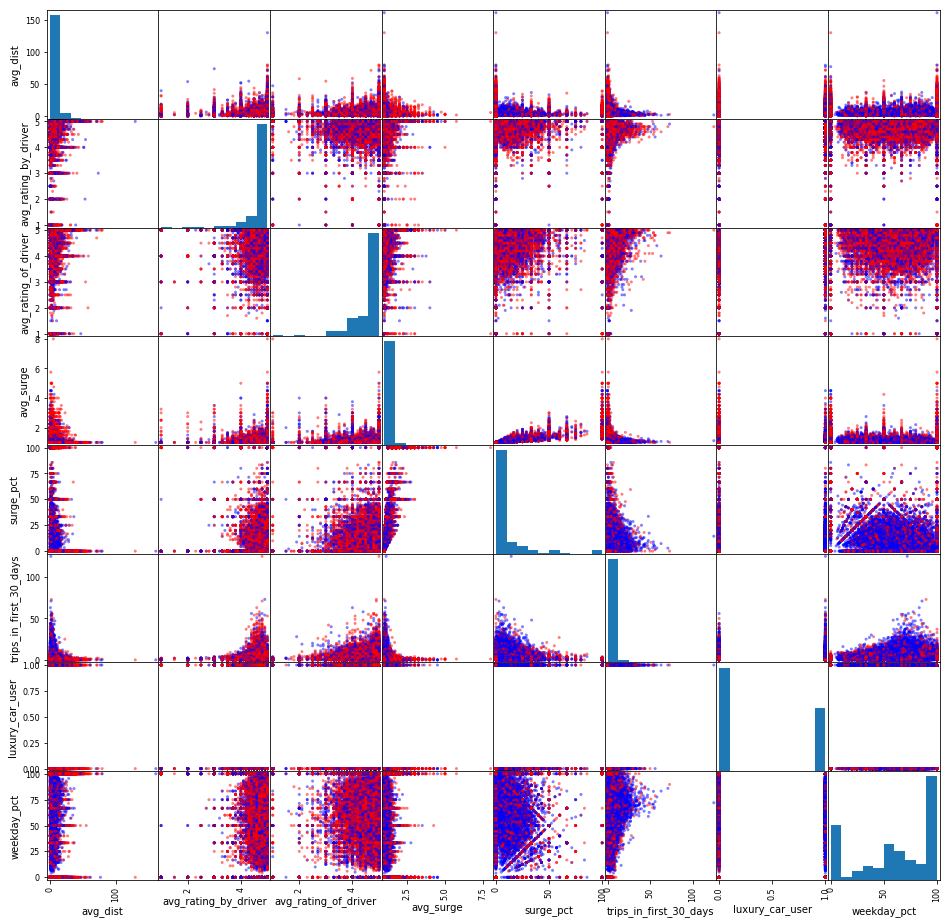

In [120]:
from pandas.plotting import scatter_matrix
colors = ['red' if ix else 'blue' for ix in df.churn]
scatter_matrix(df[core_features], figsize=(16, 16), color=colors)
plt.show()

The matrix does not show any feature will clearly seperate our churn or not churn users. Thus, we probably have a highly non-linear relationship and should consider a tree-based model. 
With intensive feature engineering, we may able to get comparable performance from logistic regression. 

In [125]:
df.groupby('churn').describe().T

churn                                    0             1
avg_dist               count  18804.000000  31196.000000
                       mean       5.114788      6.207939
                       std        4.615175      6.238675
                       min        0.000000      0.000000
                       25%        2.560000      2.320000
                       50%        3.730000      4.030000
                       75%        5.890000      7.800000
                       max      160.960000    129.890000
avg_rating_by_driver   count  18768.000000  31031.000000
                       mean       4.762772      4.787464
                       std        0.328489      0.504648
                       min        1.000000      1.000000
                       25%        4.700000      4.800000
                       50%        4.800000      5.000000
                       75%        5.000000      5.000000
                       max        5.000000      5.000000
avg_rating_of_driver   count  17172.000000  24706.000000
                       mean       4.592930      4.607557
                       std        0.542386      0.664418
                       min        1.000000      1.000000
                       25%        4.300000      4.400000
                       50%        4.800000      5.000000
                       75%        5.000000      5.000000
                       max        5.000000      5.000000
avg_surge              count  18804.000000  31196.000000
                       mean       1.073809      1.075339
                       std        0.163170      0.251361
                       min        1.000000      1.000000
                       25%        1.000000      1.000000
                       50%        1.000000      1.000000
...                                    ...           ...
signup_year            std        0.000000      0.000000
                       min     2014.000000   2014.000000
                       25%     2014.000000   2014.000000
                       50%     2014.000000   2014.000000
                       75%     2014.000000   2014.000000
                       max     2014.000000   2014.000000
surge_pct              count  18804.000000  31196.000000
                       mean       9.152797      8.666739
                       std       15.588704     22.179139
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%       13.300000      0.000000
                       max      100.000000    100.000000
trips_in_first_30_days count  18804.000000  31196.000000
                       mean       3.306318      1.658482
                       std        4.986743      2.654222
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        2.000000      1.000000
                       75%        4.000000      2.000000
                       max      125.000000     73.000000
weekday_pct            count  18804.000000  31196.000000
                       mean      61.389034     60.647032
                       std       29.487584     40.982688
                       min        0.000000      0.000000
                       25%       44.400000     16.700000
                       50%       64.300000     69.600000
                       75%       84.600000    100.000000
                       max      100.000000    100.000000

[88 rows x 2 columns]

### Missing data: EDA

In [98]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / df.shape[0]
missing_df.sort_values('missing_ratio', ascending=False)

,column_name,missing_count,missing_ratio
2,avg_rating_of_driver,8122,0.16244
1,avg_rating_by_driver,201,0.00402
0,avg_dist,0,0.00000
10,luxury_car_user,0,0.00000
15,last_year,0,0.00000
14,signup_month,0,0.00000
13,signup_year,0,0.00000
12,churn,0,0.00000
11,weekday_pct,0,0.00000
8,surge_pct,0,0.00000


We have a couple options for handling missing data: drop the rows if there are only a few or they are missing at random, impute the missing values, or bin the feature by quantiles (typically deciles) + a bin for missing.

In [108]:
df[df.avg_rating_of_driver.notnull()].phone.map(lambda x: x)

iPhone      29444
Android     12134
no_phone      300
Name: phone, dtype: int64

In [109]:
df[df.avg_rating_of_driver.isnull()].phone.value_counts()

iPhone      5138
Android     2888
no_phone      96
Name: phone, dtype: int64

In [117]:
df[df.avg_rating_of_driver.notnull()].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,signup_year,signup_month,last_year,last_month
count,41878.000000,41744.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.0,41878.0,41878.0,41878.000000
mean,5.465290,4.776648,4.601559,1.074095,8.908004,2.604972,61.289756,0.589952,2014.0,1.0,2014.0,4.200368
std,5.151833,0.404109,0.617338,0.200861,18.401140,4.055311,34.858046,0.491848,0.0,0.0,0.0,1.959421
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2014.0,1.0,2014.0,1.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000,0.000000,2014.0,1.0,2014.0,2.000000
50%,3.790000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,1.000000,2014.0,1.0,2014.0,5.000000
75%,6.490000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000,1.000000,2014.0,1.0,2014.0,6.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,2014.0,1.0,2014.0,7.000000


In [118]:
df[df.avg_rating_of_driver.isnull()].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,signup_year,signup_month,last_year,last_month
count,8122.000000,8055.000000,0.0,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.0,8122.0,8122.0,8122.000000
mean,7.506267,4.785984,NaN,1.078210,8.548067,0.593327,59.050948,0.799064,2014.0,1.0,2014.0,3.227407
std,7.758616,0.622122,NaN,0.310306,26.578461,0.606755,46.859739,0.400725,0.0,0.0,0.0,1.964936
min,0.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,2014.0,1.0,2014.0,1.000000
25%,2.410000,5.000000,NaN,1.000000,0.000000,0.000000,0.000000,1.000000,2014.0,1.0,2014.0,1.000000
50%,4.715000,5.000000,NaN,1.000000,0.000000,1.000000,100.000000,1.000000,2014.0,1.0,2014.0,3.000000
75%,10.720000,5.000000,NaN,1.000000,0.000000,1.000000,100.000000,1.000000,2014.0,1.0,2014.0,5.000000
max,160.960000,5.000000,NaN,5.000000,100.000000,5.000000,100.000000,1.000000,2014.0,1.0,2014.0,7.000000


This statistics make it clear that the two populations are different so rating_of_driver are almost certainly not missing at random.

### Model

In [48]:
# Model training!
X_train_whole = df.copy()
y_train_whole = X_train_whole.pop('churn')
X_true_test = df_test.copy()
y_true_test = X_true_test.pop('churn')

In [49]:
X_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,1,2,3
32555,1.60,5.0,-1.0,1.00,1,0.0,0,True,100.0,1,0,0
25635,3.56,4.6,4.5,1.02,1,6.7,5,True,53.3,1,0,0
27322,1.75,4.7,4.9,1.03,1,6.7,11,True,73.3,1,0,0
29987,6.78,5.0,4.8,1.09,0,12.5,1,False,50.0,0,1,0
13570,8.41,5.0,5.0,1.00,1,0.0,1,False,100.0,0,0,1


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_train_whole, y_train_whole, test_size=0.2)

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 25807 to 9133
Data columns (total 12 columns):
avg_dist                  32000 non-null float64
avg_rating_by_driver      32000 non-null float64
avg_rating_of_driver      32000 non-null float64
avg_surge                 32000 non-null float64
phone                     32000 non-null int64
surge_pct                 32000 non-null float64
trips_in_first_30_days    32000 non-null int64
luxury_car_user           32000 non-null int64
weekday_pct               32000 non-null float64
1                         32000 non-null uint8
2                         32000 non-null uint8
3                         32000 non-null uint8
dtypes: float64(6), int64(3), uint8(3)
memory usage: 3.8 MB


In [67]:
X_train.luxury_car_user = X_train.luxury_car_user.astype(int, inplace=True)

/Users/wen/code/pylearn/venv/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
